## K-Nearest Neighbours and K-Means Clustering

In this exercise, we shall use k-nearest neighbours (KNN) and k-means clustering for classficiation of digits from the MNIST handwritten dataset. 

KNN is a supervised learning method, whereas k-means clustering is an unsupervised learning method. 

In [120]:
! pip install threadpoolctl==3.1.0

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [121]:
import numpy as np
import timeit
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from ipywidgets import interact
#import seaborn as sns
import random
#from scipy import stats as st
#from scipy.spatial.distance import cdist
#import statistics as st

%matplotlib inline

In [122]:
#import the PCA class implemention

from MyPCA import *

In [123]:
# import MNIST dataset (might take a few seconds)

from sklearn.datasets import fetch_openml
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True, parser = 'auto')

# check the datatype and shape of the data
print(type(images), images.shape)
print(type(labels), labels.shape)

# if not in NumPy, convert the data to NumPy array

images = np.array(images)
labels = np.array(labels)

# check the shape of an individual image sample
print(type(images[0]), images[0].shape)
print(type(labels[0]), labels[0])

# select 2000 samples from the whole MNIST dataset
num_datapoints = 2000
# some preprocessing
X = (images.reshape(-1, 28*28)[:num_datapoints])/ 255 
# dividing by 255 will scale pixel values between [0, 1]
y = labels.astype(float) #convert string labels to float
y = y[:num_datapoints]

<class 'pandas.core.frame.DataFrame'> (70000, 784)
<class 'pandas.core.series.Series'> (70000,)
<class 'numpy.ndarray'> (784,)
<class 'str'> 5


In [124]:
labels_unique = np.unique(labels.astype(float))

for label in labels_unique:
    count = np.sum(y == label)
    print("Label: ", label, "| count: ", count)

Label:  0.0 | count:  191
Label:  1.0 | count:  220
Label:  2.0 | count:  198
Label:  3.0 | count:  191
Label:  4.0 | count:  214
Label:  5.0 | count:  180
Label:  6.0 | count:  200
Label:  7.0 | count:  224
Label:  8.0 | count:  172
Label:  9.0 | count:  210


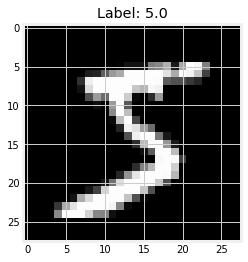

In [125]:
# plot an image
def image_plotter(X, labels, ix):
    plt.figure(figsize = (4, 4))
    plt.imshow(X[ix].reshape(28, 28), cmap = 'gray')
    plt.title('Label: '+ str(labels[ix]))
    
image_plotter(X, y, 0)

In [126]:
import numpy as np

def extract_digits(X, y, classes, samples_per_class):
    """
    Extract specified number of samples for each given digit from the MNIST dataset.

    Parameters:
    - X (np.array): Array of images from MNIST dataset.
    - y (np.array): Corresponding labels for the MNIST dataset images.
    - classes (list of int): List of digits to extract (e.g., [0, 1, 2]).
    - samples_per_class (int): Number of samples to extract for each class.

    Returns:
    - tuple of np.array: Tuple containing the extracted features matrix and labels vector.
    """
    X_extracted = []
    y_extracted = []
    
    for digit in classes:
        # Find the indices where the label equals the current digit
        indices = np.where(y == digit)[0]
        
        # Check if there are enough samples available
        if len(indices) < samples_per_class:
            raise ValueError(f"Not enough samples for digit {digit}. Only {len(indices)} available.")
        
        # Extract the samples for this digit
        selected_indices = indices[:samples_per_class]
        X_extracted.append(X[selected_indices])
        y_extracted.append(y[selected_indices])
    
    # Concatenate lists into arrays
    X_extracted = np.concatenate(X_extracted, axis=0)
    y_extracted = np.concatenate(y_extracted, axis=0)
    
    return X_extracted, y_extracted


In [127]:
classes = [1, 7]  # Digits to extract
samples_per_class = 100 # Number of samples per digit

X_classes, y_classes = extract_digits(X, y, classes, samples_per_class)
print(X_classes.shape, y_classes.shape)  # Check the shape of the extracted arrays


(200, 784) (200,)


In [128]:
y_classes[y_classes == 7].shape

(100,)

index:  42 Label:  1.0


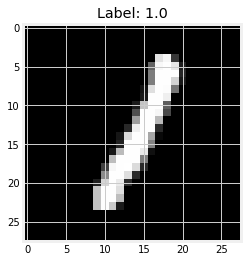

In [129]:
# plot a random image
ix_l = np.random.randint(0, len(X_classes))
print("index: ", ix_l, "Label: ", y_classes[ix_l])
image_plotter(X_classes, y_classes, ix_l)

In [130]:
# create train and test datasets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_classes, y_classes, test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape)

(134, 784) (66, 784)


## k-nearest neighbours classification

The k-nearest neighbors (k-NN) classification algorithm is a type of instance-based learning, where the function is only approximated locally and all computation is deferred until classification.

Given a new data point $x$, the algorithm finds the $k$ training examples that are closest to it in terms of distance, and then predicts the output based on the outputs of these $k$ neighbors. Let $N_k(x)$ be the set of $k$ nearest neighbors of $x$, and let $y_i$ be the output of the $i$-th nearest neighbor. The predicted output $\hat{y}$ is given by:

$$
\hat{y} = \text{mode}\{y_i : x_i \in N_k(x)\}
$$

where $\text{mode}\{.\}$ is the mode function that returns the most common value among its arguments.

The distance between two data points can be measured using various distance metrics, such as Euclidean distance, Manhattan distance, or Minkowski distance. The choice of distance metric depends on the problem at hand.

In summary, k-nearest neighbors classification works by finding the $k$ nearest neighbors of a new data point and predicting the output based on the most common output among these neighbors.


Some definitions:

1. *Instance based learning*: it makes predictions based on the specific instances of the training data, rather than constructing a general model that captures the underlying relationship between the input and output variables.

2. *Function is only approximated locally*: the prediction for a new data point is based on the outputs of its k nearest neighbors in the training data. This is in contrast to other machine learning algorithms, such as linear regression or decision trees, where a global model is constructed to approximate the function over the entire input space.

In [131]:
from sklearn.model_selection import train_test_split

def most_common(lst): # to find the mode of the labels
    return max(set(lst), key=lst.count)

def euclidean(point, data): # compute euclidean distance 
    # Euclidean distance between points a & data
    return np.sqrt(np.sum((point - data)**2, axis=1))

class My_KNeighborsClassifier:
    def __init__(self, k=5, dist_metric=euclidean):
        self.k = k
        self.dist_metric = dist_metric

    def fit(self, X_train, y_train):
        # here the distances of test samples are made w.r.t train samples
        # distances of new test samples will be computed w.r.t train samples
        # the k number of neighbours will be selected based on the distances
        # the mode of the labels for each test sample will be the label of the test sample
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        neighbors = []
        for x in X_test:
            # compute distances of sample x of test data w.r.t all training samples
            distances = self.dist_metric(x, self.X_train)
            # sort labels of neighbours according to distances (closest first) 
            y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
            # select first k nearest neighbours
            neighbors.append(y_sorted[:self.k])
        
        # use the most_common() function of the list of nearest neighbours created 
        # for each test sample
        return list(map(most_common, neighbors))

    def evaluate(self, X_test, y_test):
        # predict labels for test dataset
        y_pred = self.predict(X_test)
        # compute accuracy
        accuracy = sum(y_pred == y_test) / len(y_test)
        return accuracy




In [132]:
# Preprocess data
mypca = MyPCA(2)
mypca.fit(X_train)
X_train_reduced = mypca.transform(X_train)
X_test_reduced = mypca.transform(X_test)

my_knn = My_KNeighborsClassifier(k=5)
my_knn.fit(X_train_reduced, y_train)
test_accuracy_my_knn = my_knn.evaluate(X_test_reduced, y_test)
print("Test accuracy my knn: ", test_accuracy_my_knn.round(4))






Test accuracy my knn:  0.9394


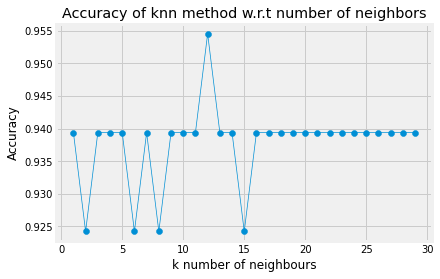

In [133]:
#Test knn model across varying ks
accuracies = []
ks = range(1, 30)
for k in ks:
    knn = My_KNeighborsClassifier(k=k)
    knn.fit(X_train_reduced, y_train)
    accuracy = knn.evaluate(X_test_reduced, y_test)
    accuracies.append(accuracy)

# Visualize accuracy vs. k
fig, ax = plt.subplots()
ax.plot(ks, accuracies, linewidth = 0.7)
ax.scatter(ks, accuracies, marker = 'o')
ax.set(xlabel="k number of neighbours",
       ylabel="Accuracy",
       title="Accuracy of knn method w.r.t number of neighbors")
plt.show()

### K-Nearest Neighbours with Scikit Learn

To know more about the KNeighborsClassifier from sklearn, refer to the documentation link below. They also have a number of examples which explain different concepts. 

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [134]:
# Here we use our pre-processed data with reduced dimensionality. 
# Preprocess data
#mypca = MyPCA(2)
#mypca.fit(X_train)
#X_train_reduced = mypca.transform(X_train)
#X_test_reduced = mypca.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier as sk_KNeighborsClassifier
from sklearn.pipeline import Pipeline

sk_knn = sk_KNeighborsClassifier(n_neighbors = 5)

In [135]:
sk_knn.fit(X_train_reduced, y_train)

KNeighborsClassifier()

In [136]:
y_test_pred_sk_knn = sk_knn.predict(X_test_reduced)
sk_knn_accuracy = np.mean(y_test_pred_sk_knn == y_test)
print("Test accuracy sk learn KNN: ", sk_knn_accuracy.round(4))

Test accuracy sk learn KNN:  0.9394


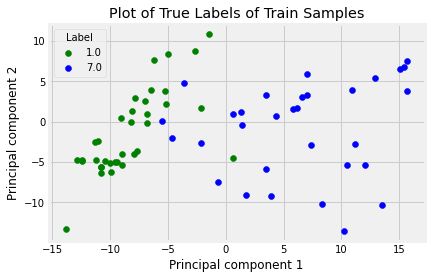

In [137]:
# Plot samples

colors = {7: 'blue', 1: 'green'}
fig, ax = plt.subplots()

# Set to keep track of which labels have been added to the legend
legend_labels = set()

for point, label in zip(X_test_reduced, y_test):
    if label not in legend_labels:
        ax.scatter(point[0], point[1], c=colors[label], label=label)
        legend_labels.add(label)  # Mark this label as added
    else:
        ax.scatter(point[0], point[1], c=colors[label])

# Add a legend, labels, and title
ax.legend(title='Label')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Plot of True Labels of Train Samples')
plt.show()

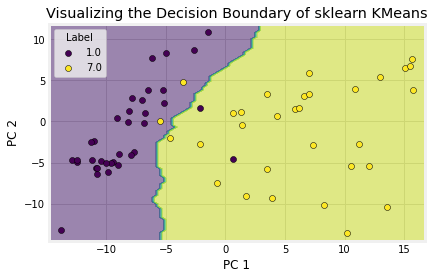

In [138]:
from sklearn.inspection import DecisionBoundaryDisplay

# Plotting the decision boundary
disp_sk_knn = DecisionBoundaryDisplay.from_estimator(
       sk_knn, X_test_reduced, response_method = 'predict',
       xlabel = 'PC 1', ylabel = 'PC 2', alpha = 0.5)

# Prepare to track labels and assign colors
unique_labels = np.unique(y_test)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Use a colormap
label_color_dict = dict(zip(unique_labels, colors))

# Set to keep track of which labels have been added to the legend
legend_labels = set()

# Plot each point, ensuring each label is added to the legend only once
for point, label in zip(X_test_reduced, y_test):
    if label not in legend_labels:
        disp_sk_knn.ax_.scatter(point[0], point[1], color=label_color_dict[label], label=label, edgecolor='k')
        legend_labels.add(label)  # Mark this label as added
    else:
        disp_sk_knn.ax_.scatter(point[0], point[1], color=label_color_dict[label], edgecolor='k')

# Add a legend, title and show plot
plt.legend(title='Label')
plt.title("Visualizing the Decision Boundary of sklearn KMeans")
plt.show()

## K-means clustering

### Unsupervised learning

Unsupervised learning, also known as unsupervised machine learning, uses machine learning algorithms to analyze and cluster unlabeled datasets. These algorithms discover hidden patterns or data groupings without the need for human intervention. Its ability to discover similarities and differences in information make it the ideal solution for exploratory data analysis, cross-selling strategies, customer segmentation, and image recognition. 

[source](https://www.ibm.com/topics/unsupervised-learning)

There is no specific $y$ variable, hence there is no clear ***correct*** answer.

An example of this class of problem is:

1. You are working for a T-shirt designing company. Your task is to narrow down the sizes of the T-shirts. The T-shirt has 2 variables - length and width. You have collected data from potential buyers. You have their length and width. These data points are however scattered, and you need to decide on 3 particular sizes(S, M and L).

### How would you go about solving this problem?

The k-means clustering algorithm works by iteratively performing 2 steps:

Step 1. assigning each data point to one of k clusters based on the distance between the data point and the cluster’s centroid

Step 2. updating the centroid of each cluster based on the mean of the data points assigned to it.

#### Defining it more clearly

Let $x_1, x_2, ..., x_n$ be the $n$ data points, and let $c_1, c_2, ..., c_k$ be the centroids of the $k$ clusters. The objective of k-means clustering is to minimize the within-cluster sum of squares (WCSS), which is given by:

$$
\sum_{i=1}^k \sum_{x \in c_i} ||x - \mu_i||^2
$$

where $\mu_i$ is the mean of the data points in cluster $c_i$.

The k-means clustering algorithm works by iteratively assigning each data point to the cluster with the nearest centroid and then updating the centroid of each cluster based on the mean of the data points assigned to it. The algorithm terminates when the assignments no longer change.

The assignment step can be expressed mathematically as:

$$
c_i = \{x : ||x - \mu_i|| \leq ||x - \mu_j|| \text{ for all } 1 \leq j \leq k\}
$$

The update step can be expressed mathematically as:

$$
\mu_i = \frac{1}{|c_i|} \sum_{x \in c_i} x
$$

#### Algorithm

1) Choose the number of clusters k

2) Initialize the centroids for each cluster

3) Assign each point to the closest cluster centroid

4) Compute the two centroids of newly formed clusters

5) Repeat the previous two steps, until there is no change in the centroid positions

##### Note: KMeans clustering predicts the clusters to which the samples belong. Hence, their outputs are not the labels itself and need to be mapped to the corresponding labels.

In [139]:
class My_KMeans:
    def __init__(self, n_clusters, centroids = None, max_iter=300, tol=1e-6):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = centroids

    def fit(self, X):
        n_samples, n_features = X.shape
        
        # initialize centroids for clusters
        if self.centroids == None:
        # Randomly initialize the centroids as k random samples from X
            random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
            #random_indices = np.arange(0, self.n_clusters, 1) 
            self.centroids = X[random_indices]

        for _ in range(self.max_iter):
            # Assign clusters based on the closest centroid
            distances = self._compute_distances(X)
            self.labels_ = np.argmin(distances, axis=1)

            # Compute new centroids
            # for each cluster 'i', its centroid is computed by taking the mean of all points
            new_centroids = np.array([X[self.labels_ == i].mean(axis=0) for i in range(self.n_clusters)])
            
            # Check for convergence (criteria: change in the centroid positions is less than tolerance)
            if np.all(np.abs(new_centroids - self.centroids) <= self.tol):
                break
            
            # update centroids
            self.centroids = new_centroids

    def predict(self, X):
        distances = self._compute_distances(X)
        return np.argmin(distances, axis=1)

    def _compute_distances(self, X):
        return np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)

In [140]:
def map_kmeans_labels_to_original(kmeans_labels, original_labels):
    """
    Map KMeans cluster labels to the most common original label in each cluster.

    Parameters:
    - kmeans_labels (np.array): Array of labels generated by KMeans.
    - original_labels (np.array): Array of original labels for the data.

    Returns:
    - np.array: Array of original labels mapped from KMeans labels.
    """
    # Initialize an empty dictionary to store the mapping from KMeans labels to original labels
    label_mapping = {}

    # Identify the most common original label in each cluster
    for cluster_label in np.unique(kmeans_labels):
        # Find indices where the cluster label matches
        indices = np.where(kmeans_labels == cluster_label)
        # Extract original labels corresponding to these indices
        original_labels_in_cluster = original_labels[indices]
        # Find the most frequent label
        values, counts = np.unique(original_labels_in_cluster, return_counts=True)
        most_common_label = values[np.argmax(counts)]
        # Map the cluster label to the most common original label
        label_mapping[cluster_label] = most_common_label

    # Apply the mapping to the KMeans labels to create a mapped label array
    mapped_labels = np.array([label_mapping[label] for label in kmeans_labels])

    return mapped_labels

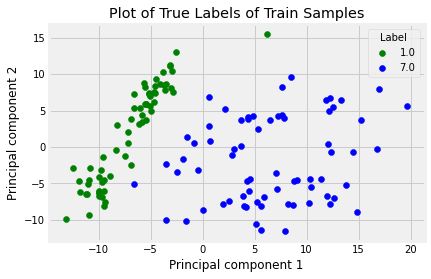

In [141]:
# Preprocess data
#mypca = MyPCA(2)
#mypca.fit(X_train)
#X_train_reduced = mypca.transform(X_train)
#X_test_reduced = mypca.transform(X_test)

# Plot samples

colors = {7: 'blue', 1: 'green'}
fig, ax = plt.subplots()

# Set to keep track of which labels have been added to the legend
legend_labels = set()

for point, label in zip(X_train_reduced, y_train):
    if label not in legend_labels:
        ax.scatter(point[0], point[1], c=colors[label], label=label)
        legend_labels.add(label)  # Mark this label as added
    else:
        ax.scatter(point[0], point[1], c=colors[label])

# Add a legend, labels, and title
ax.legend(title='Label')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Plot of True Labels of Train Samples')
plt.show()

In [165]:
my_kmeans = My_KMeans(n_clusters = 2)
my_kmeans.fit(X_train_reduced)

In [166]:
clusters_my = my_kmeans.predict(X_train_reduced)
# convert predicted labels from '0 and 1' to '7 and 1'
y_train_pred_my_kmeans = map_kmeans_labels_to_original(clusters_my, y_train)

train_accuracy_kmeans = np.mean(y_train_pred_my_kmeans == y_train)
print('Train accuracy kmeans: ', train_accuracy_kmeans.round(4))

Train accuracy kmeans:  0.8955


In [144]:
np.unique(clusters_my) #the predictions of the KMeans clustering are the cluster indices

array([0, 1], dtype=int64)

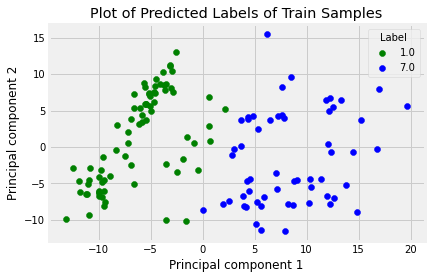

In [167]:
# Plot predictions of train samples

colors = {7: 'blue', 1: 'green'}
fig, ax = plt.subplots()

# Set to keep track of which labels have been added to the legend
legend_labels = set()

for point, label in zip(X_train_reduced, y_train_pred_my_kmeans):
    if label not in legend_labels:
        ax.scatter(point[0], point[1], c=colors[label], label=label)
        legend_labels.add(label)  # Mark this label as added
    else:
        ax.scatter(point[0], point[1], c=colors[label])

# Add a legend, labels, and title
ax.legend(title='Label')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Plot of Predicted Labels of Train Samples')
plt.show()

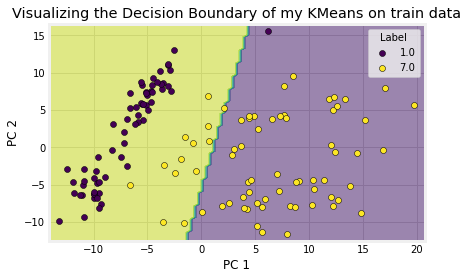

In [168]:
# Plotting the decision boundary
disp1 = DecisionBoundaryDisplay.from_estimator(
    my_kmeans, X_train_reduced, response_method='predict',
    xlabel='PC 1', ylabel='PC 2', alpha=0.5
)

# Prepare to track labels and assign colors
unique_labels = np.unique(y_train)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Use a colormap
label_color_dict = dict(zip(unique_labels, colors))

# Set to keep track of which labels have been added to the legend
legend_labels = set()

# Plot each point, ensuring each label is added to the legend only once
for point, label in zip(X_train_reduced, y_train):
    if label not in legend_labels:
        disp1.ax_.scatter(point[0], point[1], color=label_color_dict[label], label=label, edgecolor='k')
        legend_labels.add(label)  # Mark this label as added
    else:
        disp1.ax_.scatter(point[0], point[1], color=label_color_dict[label], edgecolor='k')

# Add a legend, title and show plot
plt.legend(title='Label')
plt.title("Visualizing the Decision Boundary of my KMeans on train data")
plt.show()

In [175]:
from sklearn.inspection import DecisionBoundaryDisplay

def plot_decision_boundary(estimator, X, y, title = 'Decision boundary', key = {0: 1.0, 1: 7.0}):
    
     # Plotting the decision boundary
    disp = DecisionBoundaryDisplay.from_estimator(
           estimator, X, response_method = 'predict',
           xlabel = 'PC 1', ylabel = 'PC 2', alpha = 0.5)

    # Prepare to track labels and assign colors
    unique_labels = np.unique(y)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Use a colormap
    label_color_dict = dict(zip(unique_labels, colors))

    # Set to keep track of which labels have been added to the legend
    legend_labels = set()

    # Plot each point, ensuring each label is added to the legend only once
    for point, label in zip(X, y):
        label = key[label]
        if label not in legend_labels:
            disp.ax_.scatter(point[0], point[1], color=label_color_dict[label], label=label, edgecolor='k')
            legend_labels.add(label)  # Mark this label as added
        else:
            disp.ax_.scatter(point[0], point[1], color=label_color_dict[label], edgecolor='k')

    # Add a legend, title and show plot
    if label is not None:
        plt.legend(key)
    plt.legend(title='Label')
    plt.title(title)
    plt.show()   

In [176]:
def map_kmeans_labels_to_original(kmeans_labels, original_labels):
    """
    Map KMeans cluster labels to the most common original label in each cluster.

    Parameters:
    - kmeans_labels (np.array): Array of labels generated by KMeans.
    - original_labels (np.array): Array of original labels for the data.

    Returns:
    - np.array: Array of original labels mapped from KMeans labels.
    """
    # Initialize an empty dictionary to store the mapping from KMeans labels to original labels
    label_mapping = {}

    # Identify the most common original label in each cluster
    for cluster_label in np.unique(kmeans_labels):
        # Find indices where the cluster label matches
        indices = np.where(kmeans_labels == cluster_label)
        # Extract original labels corresponding to these indices
        original_labels_in_cluster = original_labels[indices]
        # Find the most frequent label
        values, counts = np.unique(original_labels_in_cluster, return_counts=True)
        most_common_label = values[np.argmax(counts)]
        # Map the cluster label to the most common original label
        label_mapping[cluster_label] = most_common_label
    
    
    # Apply the mapping to the KMeans labels to create a mapped label array
    mapped_labels = np.array([label_mapping[label] for label in kmeans_labels])

    return mapped_labels, label_mapping

In [169]:
print(colors)

[[0.267004 0.004874 0.329415 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]


In [170]:
print(label_color_dict)

{1.0: array([0.267004, 0.004874, 0.329415, 1.      ]), 7.0: array([0.993248, 0.906157, 0.143936, 1.      ])}


In [174]:
print(disp1.ax_)

Axes(0.08,0.125;0.87x0.755)


In [173]:
help(disp1)

Help on DecisionBoundaryDisplay in module sklearn.inspection._plot.decision_boundary object:

class DecisionBoundaryDisplay(builtins.object)
 |  DecisionBoundaryDisplay(*, xx0, xx1, response, xlabel=None, ylabel=None)
 |  
 |  Decisions boundary visualization.
 |  
 |  It is recommended to use
 |  :func:`~sklearn.inspection.DecisionBoundaryDisplay.from_estimator`
 |  to create a :class:`DecisionBoundaryDisplay`. All parameters are stored as
 |  attributes.
 |  
 |  Read more in the :ref:`User Guide <visualizations>`.
 |  
 |  .. versionadded:: 1.1
 |  
 |  Parameters
 |  ----------
 |  xx0 : ndarray of shape (grid_resolution, grid_resolution)
 |      First output of :func:`meshgrid <numpy.meshgrid>`.
 |  
 |  xx1 : ndarray of shape (grid_resolution, grid_resolution)
 |      Second output of :func:`meshgrid <numpy.meshgrid>`.
 |  
 |  response : ndarray of shape (grid_resolution, grid_resolution)
 |      Values of the response function.
 |  
 |  xlabel : str, default=None
 |      Defaul

## K-Means Clustering with Scikit Learn

Lets see the sklearn approach of using K-Means

In [148]:
X_train_reduced.shape

(134, 2)

In [149]:
# we shall use the data with reduced dimensionality to two principal components

from sklearn.cluster import KMeans as sk_KMeans

sk_kmeans = sk_KMeans(n_clusters = 2, random_state = 0, n_init = "auto", max_iter=300, tol=1e-6)
sk_kmeans.fit(X_train_reduced)

C:\Users\narkh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=2, n_init='auto', random_state=0, tol=1e-06)

In [150]:
clusters_test_sk = sk_kmeans.predict(X_test_reduced)
y_test_pred_sk_kmeans = map_kmeans_labels_to_original(clusters_test_sk, y_test)

In [151]:
clusters_test_my = my_kmeans.predict(X_test_reduced)
y_test_pred_my_kmeans = map_kmeans_labels_to_original(clusters_test_my, y_test)

In [152]:
test_accuracy_my_kmeans = np.mean(y_test_pred_my_kmeans == y_test)
test_accuracy_sk_kmeans = np.mean(y_test_pred_sk_kmeans == y_test)

print("Test accuracy with my KMeans: ", test_accuracy_my_kmeans)
print("Test accuracy with sklearn KMeans: ", test_accuracy_sk_kmeans)


Test accuracy with my KMeans:  0.6212121212121212
Test accuracy with sklearn KMeans:  0.8787878787878788


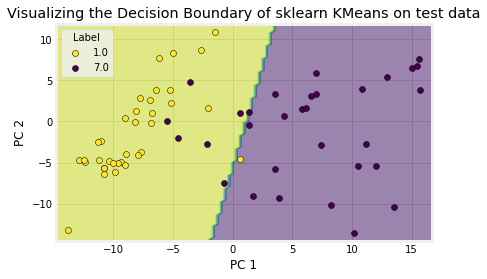

In [153]:
# Plotting the decision boundary
disp2 = DecisionBoundaryDisplay.from_estimator(
    sk_kmeans, X_test_reduced, response_method='predict',
    xlabel='PC 1', ylabel='PC 2', alpha=0.5
)

# Prepare to track labels and assign colors
unique_labels = np.unique(y_test)
colors = plt.cm.viridis(np.linspace(1, 0, len(unique_labels)))  # Use a colormap
label_color_dict = dict(zip(unique_labels, colors))

# Set to keep track of which labels have been added to the legend
legend_labels = set()

# Plot each point, ensuring each label is added to the legend only once
for point, label in zip(X_test_reduced, y_test):
    if label not in legend_labels:
        disp2.ax_.scatter(point[0], point[1], color=label_color_dict[label], label=label, edgecolor='k')
        legend_labels.add(label)  # Mark this label as added
    else:
        disp2.ax_.scatter(point[0], point[1], color=label_color_dict[label], edgecolor='k')

# Add a legend, title and show plot
plt.legend(title='Label')
plt.title("Visualizing the Decision Boundary of sklearn KMeans on test data")
plt.show()

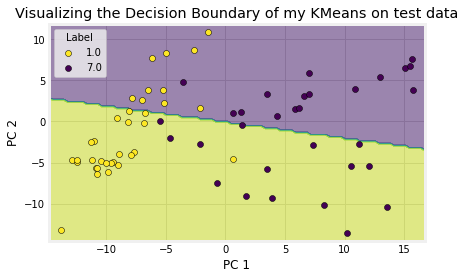

In [156]:
# Plotting the decision boundary
disp3 = DecisionBoundaryDisplay.from_estimator(
       my_kmeans, X_test_reduced, response_method = 'predict',
       xlabel = 'PC 1', ylabel = 'PC 2', alpha = 0.5)

# Prepare to track labels and assign colors
unique_labels = np.unique(y_test)
colors = plt.cm.viridis(np.linspace(1, 0, len(unique_labels)))  # Use a colormap
label_color_dict = dict(zip(unique_labels, colors))

# Set to keep track of which labels have been added to the legend
legend_labels = set()

# Plot each point, ensuring each label is added to the legend only once
for point, label in zip(X_test_reduced, y_test):
    if label not in legend_labels:
        disp3.ax_.scatter(point[0], point[1], color=label_color_dict[label], label=label, edgecolor='k')
        legend_labels.add(label)  # Mark this label as added
    else:
        disp3.ax_.scatter(point[0], point[1], color=label_color_dict[label], edgecolor='k')

# Add a legend, title and show plot
plt.legend(title='Label')
plt.title("Visualizing the Decision Boundary of my KMeans on test data")
plt.show()

In [117]:
label_color_dict

{1.0: array([0.267004, 0.004874, 0.329415, 1.      ]),
 7.0: array([0.993248, 0.906157, 0.143936, 1.      ])}

In [118]:
disp3

NameError: name 'disp3' is not defined

In [116]:
accuracies = []
for n_components in range(1, 20):
    mypca = MyPCA(n_components)
    mypca.fit(X_train)
    X_train_reduced = mypca.transform(X_train)
    X_test_reduced = mypca.transform(X_test)
    
    kmeans = KMeans(n_clusters = 2) #constant number of clusters
    kmeans.fit(X_train_reduced)
    y_train_pred = kmeans.predict(X_train_reduced)
    # convert predicted labels from '0 and 1' to '7 and 1'
    y_train_pred[y_train_pred == 0] = 7
    train_accuracy_kmeans = np.mean(y_train_pred == y_train)
    print("n_component: ", n_components, 'accuracy: ', train_accuracy_kmeans.round(4))
    accuracies.append(train_accuracy_kmeans)


NameError: name 'KMeans' is not defined

Text(0.5, 1.0, 'Accuracy of KMeans w.r.t number of principal components')

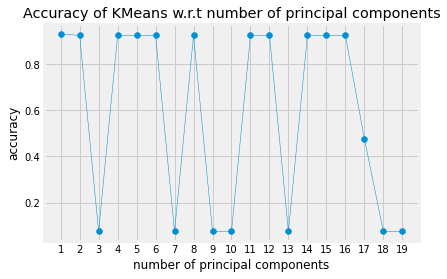

In [67]:
plt.plot(np.arange(1, 20, 1), accuracies, linewidth = 0.5)
plt.scatter(np.arange(1, 20, 1), accuracies, marker = 'o')
plt.xlabel('number of principal components')
plt.xticks(np.arange(1, 20, 1))
plt.ylabel('accuracy')
plt.title('Accuracy of KMeans w.r.t number of principal components')

### Hyperparameters

#### How to decide the hyperparameters here ? :

1) Number of neighbours in knn.

2) Number of clusters in kmeans.

3) Appropriate number of principal components. 


### Cross-Validation



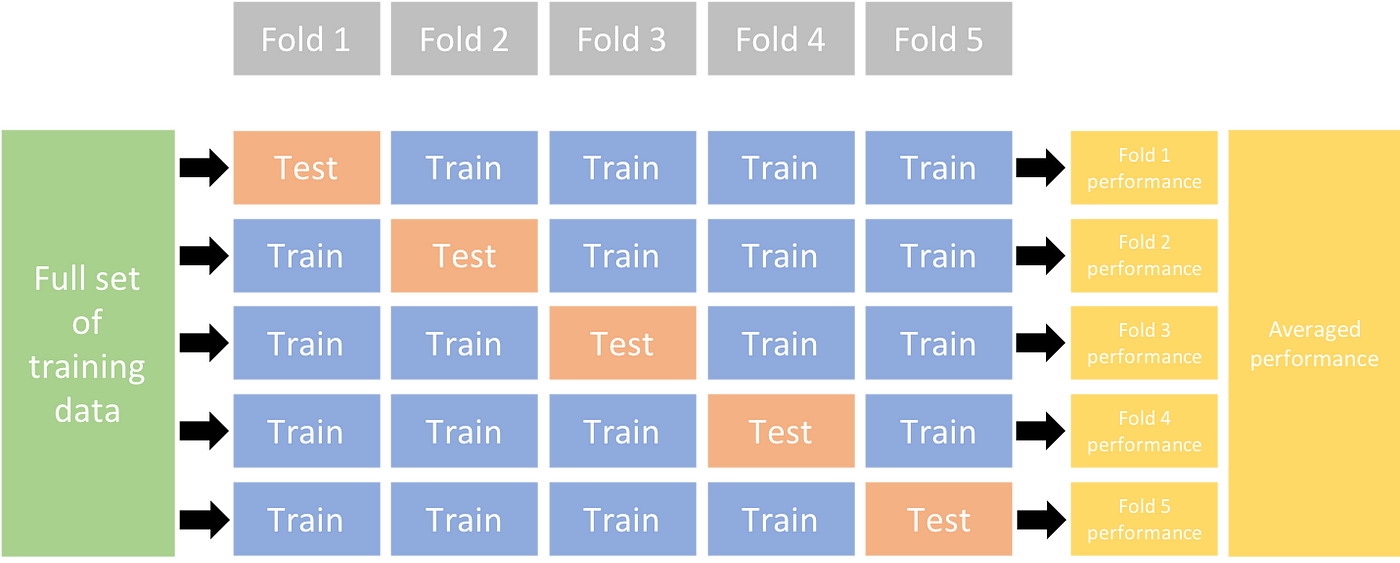

### Grid Search

Grid search exhaustively generates all the possible (hyper-)parameter combinations from the given set of parameter values. Then it trains the model with all these combinaitions of hyperparameter, computes the performance metric and returns the parameters that lead to the best performance. 

In [68]:
# Example parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7],
    'n_components': [10, 20, 30, 40, 50]
}

param_combos = []
    
for n_neighbor in param_grid['n_neighbors']:
    for n_component in param_grid['n_components']:
        
        param_combo = {
            'n_neighbors': n_neighbor,
            'n_components': n_component
        }
        param_combos.append(param_combo)
        
print(param_combos, len(param_combos))

[{'n_neighbors': 3, 'n_components': 10}, {'n_neighbors': 3, 'n_components': 20}, {'n_neighbors': 3, 'n_components': 30}, {'n_neighbors': 3, 'n_components': 40}, {'n_neighbors': 3, 'n_components': 50}, {'n_neighbors': 5, 'n_components': 10}, {'n_neighbors': 5, 'n_components': 20}, {'n_neighbors': 5, 'n_components': 30}, {'n_neighbors': 5, 'n_components': 40}, {'n_neighbors': 5, 'n_components': 50}, {'n_neighbors': 7, 'n_components': 10}, {'n_neighbors': 7, 'n_components': 20}, {'n_neighbors': 7, 'n_components': 30}, {'n_neighbors': 7, 'n_components': 40}, {'n_neighbors': 7, 'n_components': 50}] 15


In [69]:
def k_fold_split(X, y, k=5):
    """Splits data into k folds for cross-validation"""
    fold_size = len(X) // k
    indices = np.arange(len(X))
    #np.random.shuffle(indices)
    
    folds = []
    for i in range(k):
        val_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.setdiff1d(indices, val_indices)
        folds.append((train_indices, val_indices))
    
    return folds


from tqdm import tqdm

def grid_search_cv(X, y, param_grid, k_folds = 5, model = 'kmeans', centroids = None):
    
    best_score = -np.inf
    best_params = None
    
    param_combinations = []
    
    if model == 'knn':
    
        for n_neighbor in param_grid['n_neighbors']:
            for n_component in param_grid['n_components']:
        
                param_combo = {
                    'n_neighbors': n_neighbor,
                    'n_components': n_component
                }
                param_combinations.append(param_combo)
                
                
    elif model == 'kmeans':
        
        for n_clusters in param_grid['n_clusters']:
            for n_component in param_grid['n_components']:
                
                param_combo = {
                    'n_clusters': n_clusters,
                    'n_components': n_component
                }
                param_combinations.append(param_combo)                
    
    folds = k_fold_split(X, y, k = k_folds)
    
    with tqdm(total=len(param_combinations) * k_folds, desc='Grid Search') as pbar:
        for params in param_combinations: 
            cv_scores = []
        
            for train_indices, val_indices in folds: 
                X_train, X_val = X[train_indices], X[val_indices]
                y_train, y_val = y[train_indices], y[val_indices]
            
                #apply PCA
                mypca = MyPCA(params['n_components'])
                mypca.fit(X_train)
                X_train_pca = mypca.transform(X_train)
                X_val_pca = mypca.transform(X_val)
            
                #train with KNN
                if model == 'knn':
                
                    knn = KNeighborsClassifier(k = params['n_neighbors'])
                    knn.fit(X_train_pca, y_train)
            
                    #validate model
                    #y_val_pred = knn.predict(X_val_pca)
                    accuracy = knn.evaluate(X_val_pca, y_val)
                    cv_scores.append(accuracy)
                
                elif model == 'kmeans':
                    
                    kmeans = KMeans(n_clusters = params['n_clusters'])
                    kmeans.fit(X_train_pca)
                    
                    #validate model
                    y_val_pred = kmeans.predict(X_val_pca)
                    accuracy = np.mean(y_val_pred == y_val)
                    cv_scores.append(accuracy)
                
                pbar.update(1)
                
            mean_cv_score = np.mean(cv_scores)
        
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_params = params
    
    return best_params, best_score

In [70]:
# KNN hyperparameters: number of principal components, number of nearest neighbours

# Example parameter grid
param_grid = {
    'n_neighbors': [5, 7, 9, 11],
    'n_components': [10, 20, 30]
}

best_params, best_score = grid_search_cv(X_train, y_train, param_grid, k_folds = 5, model = 'knn')

print("Best Parameters: ", best_params)
print("Best Cross-Validation Accuracy: {:.2f}".format(best_score))

Grid Search: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.28it/s]

Best Parameters:  {'n_neighbors': 5, 'n_components': 10}
Best Cross-Validation Accuracy: 0.97


In [71]:
# Test accuracy using the best parameters

# Preprocess data
mypca = MyPCA(10)
mypca.fit(X_train)
X_train_reduced = mypca.transform(X_train)
X_test_reduced = mypca.transform(X_test)


knn_best = KNeighborsClassifier(k = 5)
knn_best.fit(X_train_reduced, y_train)

test_accuracy = knn_best.evaluate(X_test_reduced, y_test)

print("Test accuracy KNN: ", test_accuracy.round(4))

Test accuracy KNN:  0.9697


In [74]:
# KMeans 

# Preprocess data
mypca = MyPCA(2)
mypca.fit(X_train)
X_train_reduced = mypca.transform(X_train)
X_test_reduced = mypca.transform(X_test)
y_train_encoded = y_train.copy() 
y_train_encoded[y_train == 7] = 0

param_grid_kmeans = {
    'n_clusters': [2], # since we already know its a binary class. 
    'n_components': [10, 50, 200]
}

# Perform grid search CV for KMeans
best_params_kmeans, best_score_kmeans = grid_search_cv(X_train, y_train_encoded, param_grid_kmeans, centroids = None, k_folds=5, model='kmeans')
print("Best KMeans Parameters: ", best_params_kmeans)
print("Best KMeans Cross-Validation Accuracy: {:.2f}".format(best_score_kmeans))

Grid Search: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.32it/s]

Best KMeans Parameters:  {'n_clusters': 2, 'n_components': 200}
Best KMeans Cross-Validation Accuracy: 0.45


In [75]:
# Test accuracy for KMeans with best params

# Preprocess data
mypca = MyPCA(200)
mypca.fit(X_train)
X_train_reduced = mypca.transform(X_train)
X_test_reduced = mypca.transform(X_test)


kmeans_best = KMeans(n_clusters = 2)
kmeans_best.fit(X_train_reduced)
y_test_pred = kmeans_best.predict(X_test_reduced)
y_test_pred[y_test_pred == 0] = 7
test_accuracy_Kmeans = np.mean(y_test_pred == y_test)



print("Test accuracy for KMeans: ", test_accuracy_Kmeans.round(4))

Test accuracy for KMeans:  0.9242


## Effect of scaling the data

For distance based methods such as K-Nearest Neighbors and KMeans Clustering, scaling the data before applying the method is necessary. The code blocks below show the effect of scaling the data. 

### Mathematical Explanation

Consider two features in a dataset, $A$ and $B$. Suppose $A$ ranges from 0 to 1000, and $B$ ranges from 0 to 1. The Euclidean distance $d$ between two points $x = (x_A, x_B)$ and $y = (y_A, y_B)$ is calculated as:

$$
dist(x, y) = \sqrt{(x_A - y_A)^2 + (x_B - y_B)^2}
$$

Here, the larger scale of $A$ will dominate the distance calculation, making changes in $B$ almost irrelevant, even if they are crucial for clustering or classification. This demonstrates the need for feature scaling.


In [80]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

X, y = load_wine(return_X_y=True, as_frame=True)
scaler = StandardScaler().set_output(transform="pandas")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)
scaled_X_train = scaler.fit_transform(X_train)

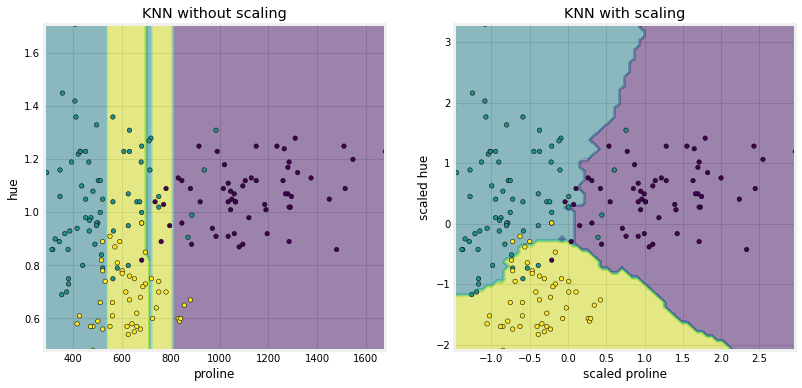

In [81]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

X_plot = X[["proline", "hue"]]
X_plot_scaled = scaler.fit_transform(X_plot)
clf = KNeighborsClassifier(n_neighbors=20)


def fit_and_plot_model(X_plot, y, clf, ax):
    clf.fit(X_plot, y)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_plot,
        response_method="predict",
        alpha=0.5,
        ax=ax,
    )
    disp.ax_.scatter(X_plot["proline"], X_plot["hue"], c=y, s=20, edgecolor="k")
    disp.ax_.set_xlim((X_plot["proline"].min(), X_plot["proline"].max()))
    disp.ax_.set_ylim((X_plot["hue"].min(), X_plot["hue"].max()))
    return disp.ax_


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

fit_and_plot_model(X_plot, y, clf, ax1)
ax1.set_title("KNN without scaling")

fit_and_plot_model(X_plot_scaled, y, clf, ax2)
ax2.set_xlabel("scaled proline")
ax2.set_ylabel("scaled hue")
_ = ax2.set_title("KNN with scaling")